In [1]:
import kagglehub
import shutil

# Download the dataset
download_path = kagglehub.dataset_download("gannayasser/arabic-alphabets-sign-language-dataset-arasl")

# Move it to your target path
target_path = "./Dataset"
shutil.move(download_path, target_path)



100%|██████████| 70.7M/70.7M [00:04<00:00, 16.3MB/s]

Extracting files...


'./Dataset'

### Importing

In [10]:
# Standard libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# TorchVision
from torchvision import transforms, models

# Utilities
from tqdm import tqdm

# Metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


### Settings

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (32, 32)
TRAIN_SPLIT = 0.8
SEED = 42
EPOCH = 10
LR = 0.01
ROOT_DIR = "/content/Dataset/ArASL_Database_54K_Final/ArASL_Database_54K_Final"

### Create a custom dataset

In [5]:
import os
import glob
from torch.utils.data import Dataset
from PIL import Image

class ArASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.label_to_idx = {}

        labels = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.label_to_idx = {label: idx for idx, label in enumerate(labels)}

        image_exts = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']

        for label in labels:
            label_folder = os.path.join(root_dir, label)
            image_paths = set()
            for ext in image_exts:
                image_paths.update(glob.glob(os.path.join(label_folder, ext)))
            for image_path in image_paths:
                self.data.append((image_path, self.label_to_idx[label]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


### Defining the classes

In [6]:
import os
def rename_folders_and_create_mapping(folder_path):
    # Get list of directories in the folder path
    folders = sorted([
        folder for folder in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, folder))
    ])

    # Sort folders to ensure deterministic mapping
    folder_mapping = {}
    temp_mapping = {}

    # First pass: rename all to temp names to avoid conflicts
    for i, folder in enumerate(folders):
        temp_name = f"__temp__{i}"
        src = os.path.join(folder_path, folder)
        dst = os.path.join(folder_path, temp_name)
        os.rename(src, dst)
        temp_mapping[temp_name] = folder
        folder_mapping[folder] = i

    # Second pass: rename from temp names to final names
    for temp_name, original_name in temp_mapping.items():
        final_name = str(folder_mapping[original_name])
        src = os.path.join(folder_path, temp_name)
        dst = os.path.join(folder_path, final_name)
        os.rename(src, dst)

    return folder_mapping

classes = rename_folders_and_create_mapping(ROOT_DIR)
print(classes)

{'ain': 0, 'al': 1, 'aleff': 2, 'bb': 3, 'dal': 4, 'dha': 5, 'dhad': 6, 'fa': 7, 'gaaf': 8, 'ghain': 9, 'ha': 10, 'haa': 11, 'jeem': 12, 'kaaf': 13, 'khaa': 14, 'la': 15, 'laam': 16, 'meem': 17, 'nun': 18, 'ra': 19, 'saad': 20, 'seen': 21, 'sheen': 22, 'ta': 23, 'taa': 24, 'thaa': 25, 'thal': 26, 'toot': 27, 'waw': 28, 'ya': 29, 'yaa': 30, 'zay': 31}


### Defining the dataset

Original image shape (before transform): (64, 64, 3)


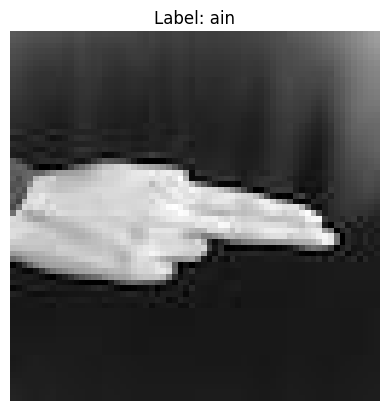

In [20]:
full_dataset = ArASLDataset(root_dir=ROOT_DIR, transform=None)

original_image, original_label = full_dataset[0]
print("Original image shape (before transform):", np.array(original_image).shape)  # (H, W, 3)
inv_classes = {v:k for k,v in classes.items()}

plt.imshow(original_image)
plt.title(f"Label: {inv_classes[int(original_label)]}")
plt.axis('off')
plt.show()

### Train and Test Split

Batch shape after transform: torch.Size([32, 3, 32, 32])
Shape of one image tensor: torch.Size([3, 32, 32])
Batch labels: tensor([30,  6,  9, 25, 14])


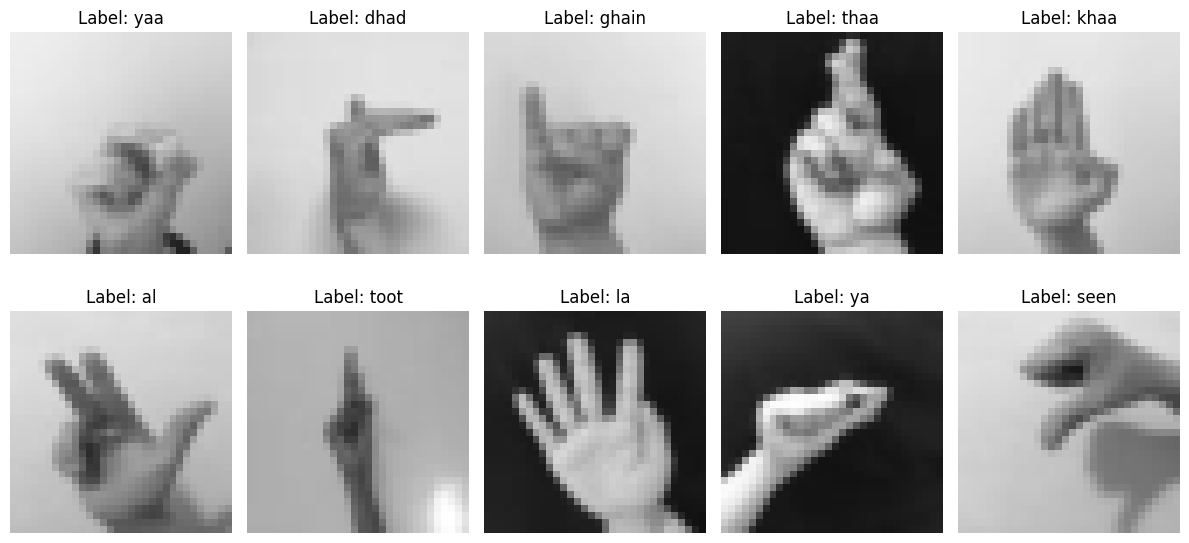

In [21]:
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

images, labels = next(iter(train_loader))
print("Batch shape after transform:", images.shape)
print("Shape of one image tensor:", images[0].shape)
print("Batch labels:", labels[:5])

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure valid image range after transforms
    ax.imshow(img)
    ax.set_title(f"Label: {inv_classes[int(labels[i])]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### Creating the model

In [22]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=32):
        super(EfficientNetModel, self).__init__()

        self.base_model = models.efficientnet_b0(pretrained=True)

        # Freeze
        # for param in self.base_model.features.parameters():
        #     param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


### Training Fucntion

In [23]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

### Validation Function


In [24]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

### Training

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNetModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_precisions, val_recalls, val_f1s = [], [], []

for epoch in range(EPOCH):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_preds, val_labels = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch+1}/{EPOCH}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_accuracy:.2f}%, "
          f"Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}")

100%|██████████| 1352/1352 [01:01<00:00, 22.16it/s]



Epoch 1/10: Train Loss=0.8970, Train Acc=73.44%, Val Loss=0.2440, Val Acc=92.91%, Precision=0.9315, Recall=0.9283, F1=0.9287


100%|██████████| 1352/1352 [01:01<00:00, 22.02it/s]



Epoch 2/10: Train Loss=0.3398, Train Acc=90.30%, Val Loss=0.2301, Val Acc=93.46%, Precision=0.9357, Recall=0.9364, F1=0.9345


100%|██████████| 1352/1352 [01:01<00:00, 21.82it/s]



Epoch 3/10: Train Loss=0.2491, Train Acc=92.94%, Val Loss=0.1649, Val Acc=95.48%, Precision=0.9568, Recall=0.9544, F1=0.9548


100%|██████████| 1352/1352 [01:03<00:00, 21.20it/s]



Epoch 4/10: Train Loss=0.2046, Train Acc=94.33%, Val Loss=0.1182, Val Acc=96.60%, Precision=0.9666, Recall=0.9653, F1=0.9656


100%|██████████| 1352/1352 [01:04<00:00, 20.97it/s]



Epoch 5/10: Train Loss=0.2089, Train Acc=94.35%, Val Loss=0.1096, Val Acc=96.92%, Precision=0.9692, Recall=0.9689, F1=0.9689


100%|██████████| 1352/1352 [01:03<00:00, 21.24it/s]



Epoch 6/10: Train Loss=0.1501, Train Acc=95.84%, Val Loss=0.1044, Val Acc=97.03%, Precision=0.9701, Recall=0.9698, F1=0.9697


100%|██████████| 1352/1352 [01:03<00:00, 21.31it/s]



Epoch 7/10: Train Loss=0.1570, Train Acc=95.76%, Val Loss=0.1152, Val Acc=96.57%, Precision=0.9666, Recall=0.9653, F1=0.9652


100%|██████████| 1352/1352 [01:04<00:00, 20.83it/s]



Epoch 8/10: Train Loss=0.1402, Train Acc=96.22%, Val Loss=0.1091, Val Acc=97.27%, Precision=0.9736, Recall=0.9722, F1=0.9726


100%|██████████| 1352/1352 [01:03<00:00, 21.32it/s]



Epoch 9/10: Train Loss=0.1237, Train Acc=96.52%, Val Loss=0.0902, Val Acc=97.59%, Precision=0.9764, Recall=0.9763, F1=0.9761


100%|██████████| 1352/1352 [01:03<00:00, 21.41it/s]



Epoch 10/10: Train Loss=0.1206, Train Acc=96.71%, Val Loss=0.0928, Val Acc=97.38%, Precision=0.9749, Recall=0.9734, F1=0.9737


### Plotting

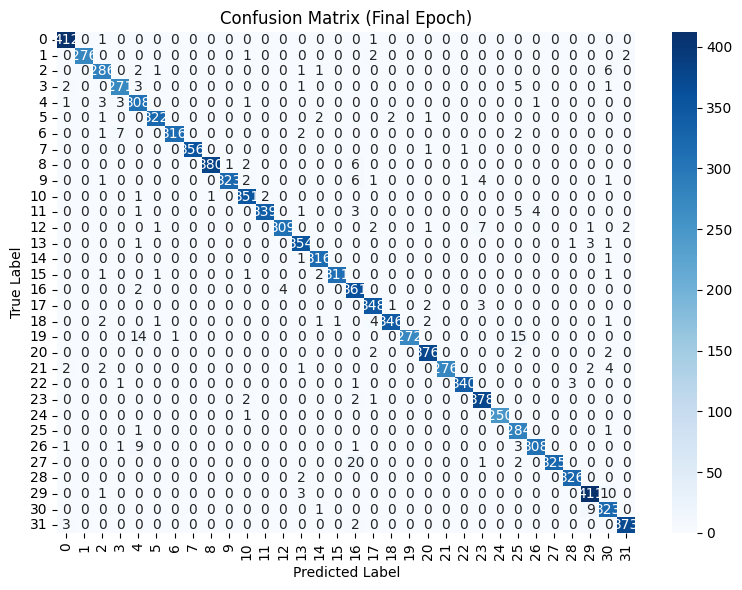

In [26]:
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Final Epoch)")
plt.tight_layout()
plt.show()


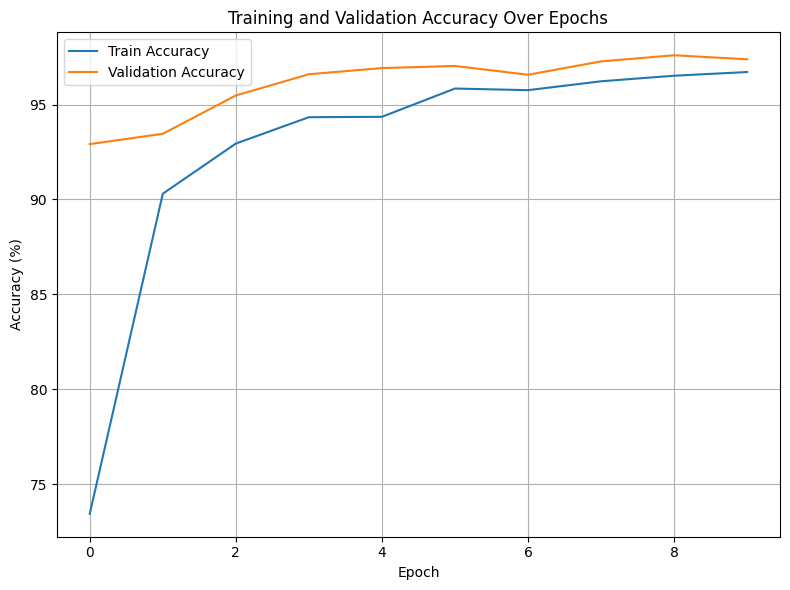

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
